In [1]:
import collections
import matplotlib.pyplot as plt
from IPython import display
import itertools as itr
import numpy as np
import copy
import math

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from common.optim.meta import MetaData
from common.optim.optimise_v6_light import NetLineStepProcessor
from common.optim.ffn_minst_optimise import \
    StepCalculatorEtaSoftmaxArmihoNorm2Base, StepCalculatorEtaSoftmaxArmihoNorm1Base
from common.ffn_minst_relu import MNISTReLU
from common.util import AverageMeter, loss_crossentropy_np

from torchvision.datasets import QMNIST
from torchvision.transforms import ToTensor

import logging

In [2]:
logging.basicConfig(filename="logs/qminst_ffn_comparison.log",
                level=logging.INFO,
                format="%(levelname)s: %(asctime)s %(message)s",
                datefmt="%m/%d/%Y %I:%M:%S")


#### Constants

In [3]:
BATCH_SIZE = 64
OUTPUT_DIM=10
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
slope_plus, slope_minus=1.0, 0.

EXPERIMENTS = 1 #3
EPOCHS_PER_EXPERIMENT = 30
DATASET_PATH = "./datasets"

#### QMNIST dataset

In [4]:
image_transform = ToTensor()

train_dataset = QMNIST(root=DATASET_PATH, train=True, download=True, transform=image_transform)
test_dataset = QMNIST(root=DATASET_PATH, train=False, download=True, transform=image_transform)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

##### UTILS

In [5]:
def eta_straightline(testNet, loss_value):
    denominator = 0.0
    for param in testNet.parameters():
        denominator += ((param.grad)**2).sum().item()
    eta = loss_value/denominator
    return eta

def calculate_accuracy(prediction, target):
    return np.average((prediction ==target).detach().cpu())

def test_loop(testNet):
    accuracy_meter, loss_meter  = AverageMeter(), AverageMeter(),
    with torch.no_grad():
        for test_batch in test_dataloader:
            images, labels = test_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            batch_size = images.shape[0]
            xx = images.view(batch_size, -1)
            logits = testNet.forward_(xx).detach().cpu()

            prediction = logits.argmax(dim=-1).to(DEVICE)
            loss = loss_crossentropy_np(np.transpose(logits.numpy()), labels)
            loss_meter.update(loss)
            accuracy_meter.update(calculate_accuracy(prediction, labels))

    return accuracy_meter.avg, loss_meter.avg


In [6]:
def experiment_comparison(data, var, low, high, title="Comparison"):

    MEAN_STRGHT = data[low:high,0]
    MEAN_SGD = data[low:high,1]
    MEAN_NETNTK2 = data[low:high,2]
    MEAN_NETSTEP = data[low:high,3]
    MEAN_NETNTK1 = data[low:high,4]
    if (var is not None):
        low, up = data[low:high]-var[low:high], data[low:high]+var[low:high]
        LOW_STRGHT, UP_STRGHT = low[:,0], up[:,0]
        LOW_SGD, UP_SGD = low[:,1], up[:,1]
        LOW_NETNTK2, UP_NETNTK2 = low[:,2], up[:,2]
        LOW_NETSTEP, UP_NETSTEP = low[:,3], up[:,3]
        LOW_NETNTK1, UP_NETNTK1 = low[:,4], up[:,4]
        cord_x = np.arange(0, len(MEAN_NETNTK2[:,1]))

    display.clear_output()
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))
    axes[0].set_title('Loss (average cross entropy)')
    axes[0].plot(MEAN_NETNTK2[:,1], color='b',alpha=.5, label='Net-line NTK norm-2')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_NETNTK2[:,1], y2=UP_NETNTK2[:,1], color='b', alpha=.125)
    axes[0].plot(MEAN_NETNTK1[:,1], color='g',alpha=.5, label='Net-line NTK norm-1')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_NETNTK1[:,1], y2=UP_NETNTK1[:,1], color='g', alpha=.125)
    axes[0].plot(MEAN_NETSTEP[:,1], color='b', ls='dotted', alpha=.5, label='Net-line 2-step')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_NETSTEP[:,1], y2=UP_NETSTEP[:,1], color='b', ls='dotted', alpha=.125)
    axes[0].plot(MEAN_STRGHT[:,1], color='orange', alpha=.5, label='Straight-line')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_STRGHT[:,1], y2=UP_STRGHT[:,1], color='orange', alpha=.125)
    axes[0].plot(MEAN_SGD[:,1], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[0].fill_between(x=cord_x, y1=LOW_SGD[:,1], y2=UP_SGD[:,1], color='grey', alpha=.125)
    axes[0].grid()
    axes[0].legend()
    axes[0].set_xlabel("Epoch (series of gradient descent steps)")
    axes[0].set_ylabel("Loss value")

    axes[1].set_title('Accuracy (top 1)')
    axes[1].plot(MEAN_NETNTK2[:,0], color='b', alpha=.5, label='Net-line NTK norm-2')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=LOW_NETNTK2[:,0], y2=UP_NETNTK2[:,0], color='b', alpha=.125)
    axes[1].plot(MEAN_NETNTK1[:,0], color='g', alpha=.5, label='Net-line NTK norm-1')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=LOW_NETNTK1[:,0], y2=UP_NETNTK1[:,0], color='g', alpha=.125)
    axes[1].plot(MEAN_NETSTEP[:,0], color='b', ls='dotted', alpha=.5, label='Net-line 2-step')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=LOW_NETSTEP[:,0], y2=UP_NETSTEP[:,0], color='b', ls='dotted', alpha=.125)
    axes[1].plot(MEAN_STRGHT[:,0], color='orange', alpha=.5, label='Straight-line')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=LOW_STRGHT[:,0], y2=UP_STRGHT[:,0], color='orange', alpha=.125)
    axes[1].plot(MEAN_SGD[:,0], color='grey', alpha=.5, label='SGD')
    if (var is not None):
        axes[1].fill_between(x=cord_x, y1=LOW_SGD[:,0], y2=UP_SGD[:,0], color='grey', alpha=.125)
    axes[1].grid()
    axes[1].legend()
    axes[1].set_xlabel("Epoch (series of gradient descent steps)")
    axes[1].set_ylabel("Accuracy value")

    dummy=fig.suptitle(title)

    plt.show()

def rf(value):
    return f"{value:.5f}"

def accuracy_comparison(exp_results, low, high, title="Validation accuracy"):
    strght_mean, strght_var = np.mean(exp_results[:, low:high, 0, 0], axis=0), np.var(exp_results[:, low:high, 0, 0], axis=0)
    sgd_mean, sgd_var = np.mean(exp_results[:, low:high, 1, 0], axis=0), np.var(exp_results[:, low:high, 1, 0], axis=0)
    nline2_mean, nline2_var = np.mean(exp_results[:, low:high, 2, 0], axis=0), np.var(exp_results[:, low:high, 2, 0], axis=0)
    nline_mean, nline_var = np.mean(exp_results[:, low:high, 3, 0], axis=0), np.var(exp_results[:, low:high, 3, 0], axis=0)
    nline1_mean, nline1_var = np.mean(exp_results[:, low:high, 4, 0], axis=0), np.var(exp_results[:, low:high, 4, 0], axis=0)

    p1, p2, p3, p4 = min(5,EPOCHS_PER_EXPERIMENT), min(10,EPOCHS_PER_EXPERIMENT)\
        , min(20,EPOCHS_PER_EXPERIMENT), min(30,EPOCHS_PER_EXPERIMENT)

    report = np.zeros((5,4), dtype='U256')
    for row in range(5):
        mean, var = (strght_mean, strght_var) if row == 0 else (sgd_mean, sgd_var) if row == 1 else \
            (nline2_mean, nline2_var) if row == 2 else (nline_mean, nline_var) if row == 3 else (nline1_mean, nline1_var)
        for col in range(4):
            indx = p1-1 if col == 0 else p2-1 if col == 1 else p3-1 if col == 2 else p4-1
            report[row, col] = rf(mean[indx]) + "+/-" + rf(var[indx])

    fig, ax = plt.subplots(figsize=(8, 8))
    # hide axes
    #fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    tab_plot = ax.table(cellText=report, colLabels=[str(p1)+' epochs',str(p2)+' epochs',str(p3)+' epochs',str(p4)+' epochs']\
        , rowLabels=['Straight-line','SGD','Net-line NTK norm-2', 'Net-line two steps', 'Net-line NTK norm-1'], cellLoc='left', loc='center')
    tab_plot.auto_set_font_size(False)
    tab_plot.set_fontsize(11)
    tab_plot.scale(3, 4)
    #fig.tight_layout()
    ax.set_title(title)
    plt.show()

#### Compare optimisers

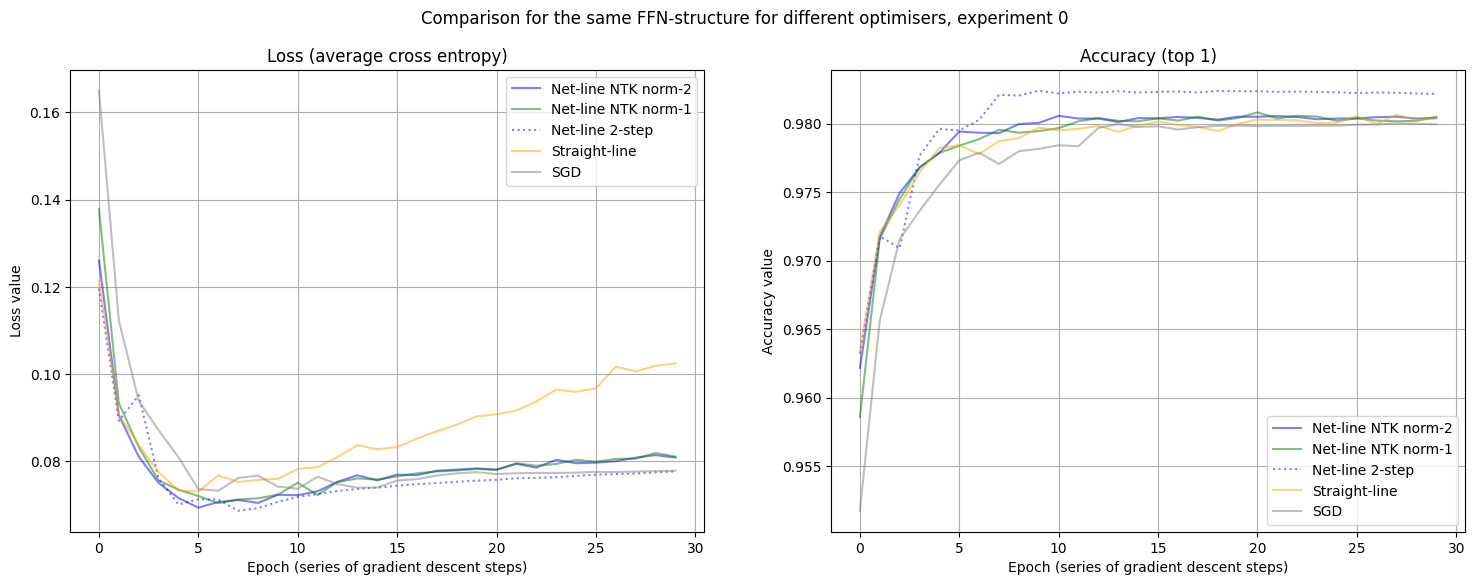

Experiment=0, net-line=0.9821761727078892, straight-line=0.980410447761194, beta_coeff=0.01


In [ ]:
#Weights distribution variances are set as in (5.67)
cb, cw = 0, 2.0/(slope_plus**2.0 + slope_minus**2.0)
meta = MetaData(batch_size = BATCH_SIZE, output_dim=OUTPUT_DIM, lb = 0.005, lw = 5.0, device=DEVICE)

'''
0-num of experiment; 1-epoch;
2-net: 0-Straight-line, 1-Sgd fixed lr, 2-Net-line NTK norm-2, 3-Net-line step, 4-Net-line NTK norm-1
3-param: 0-test accuracy (Top-1), 1-test errror (cross-entropy), 2 - qq_test
'''
experimental_results = np.zeros((EXPERIMENTS, EPOCHS_PER_EXPERIMENT, 5, 3))
eta_fixed = 0.01
qq_divider = 1.0

for experiment in range(EXPERIMENTS):

    #Straight-line
    net_straightline = MNISTReLU(input_dim=28**2, input_width=1000, hidden_width=400, output_dim=OUTPUT_DIM)
    net_straightline.set_slopes(slope_plus, slope_minus)
    net_straightline.init_weights(cb, cw)
    net_straightline.to(DEVICE)
    loss_straightline = nn.CrossEntropyLoss(reduction='sum')
    opt_straightline = optim.SGD(net_straightline.parameters(), lr=1e-2)

    #Sgd scheduled lr
    net_sgd = copy.deepcopy(net_straightline)
    net_sgd.set_slopes(slope_plus, slope_minus)
    loss_sgd = nn.CrossEntropyLoss()
    opt_sgd = optim.SGD(net_sgd.parameters(), lr=1e-2, momentum=0.9, nesterov=True) #, weight_decay=2.5e-4)

    #Net-line NTK norm2
    net_linentk2 = copy.deepcopy(net_straightline)
    net_linentk2.set_slopes(slope_plus, slope_minus)
    opt_linentk2 = StepCalculatorEtaSoftmaxArmihoNorm2Base(meta)

    #Net-line NTK norm1
    net_linentk1 = copy.deepcopy(net_straightline)
    net_linentk1.set_slopes(slope_plus, slope_minus)
    opt_linentk1 = StepCalculatorEtaSoftmaxArmihoNorm1Base(meta)

    #Net-line 2step
    net_linestep = copy.deepcopy(net_straightline)
    net_linestep.set_slopes(slope_plus, slope_minus)
    net_linestep.train(False)
    opt_linestep = NetLineStepProcessor(net_linestep, nn.CrossEntropyLoss(), meta, DEVICE)
    opt_linestep.eta1 = 0.01
    opt_linestep.alpha = 0.25
    opt_linestep.beta = 0.01
    opt_linestep.gamma = 0.1

    for epoch in range(EPOCHS_PER_EXPERIMENT):
        #lr for SGD
        lr = eta_fixed if epoch < 20 else eta_fixed * 0.1 if epoch < 40 else eta_fixed * 0.01

        mt_qq = AverageMeter()

        for train_batch in train_dataloader:
            images, labels = train_batch
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            batch_size = images.shape[0]
            xx = images.view(batch_size, -1)

            logging.info("####Step with Straight-line")
            logits1 = net_straightline.forward_(xx)
            loss1 = loss_straightline(logits1, labels)
            opt_straightline.zero_grad()
            loss1.backward()
            opt_straightline.param_groups[0]['lr'] = eta_straightline(net_straightline, loss1.item())
            opt_straightline.step()

            logging.info("####Step with SGD-optimiser fixed lr")
            logits2 = net_sgd.forward_(xx)
            loss2 = loss_sgd(logits2, labels)
            opt_sgd.zero_grad()
            loss2.backward()
            opt_sgd.param_groups[0]['lr'] = lr
            opt_sgd.step()

            logging.info("####Step with net-line norm2 NTK version")
            with torch.no_grad():
                logits4 = net_linentk2.forward_(xx)
            _, _ = opt_linentk2.step(net_linentk2, logits4.detach().cpu().numpy(), labels, xx)

            logging.info("####Step with net-line norm1 NTK version")
            with torch.no_grad():
                logits5 = net_linentk1.forward_(xx)
            _, _ = opt_linentk1.step(net_linentk1, logits5.detach().cpu().numpy(), labels, xx)

            logging.info("####Step with net-line 2-step version")
            step_result = opt_linestep.step(labels, xx, momentum=0.9, nesterov=True) #, weight_decay=2.5e-4)
            mt_qq.update(step_result.qq_norm)

        #qq_test
        experimental_results[experiment, epoch, 3, 2] = mt_qq.avg
        # testing loop
        acc0, loss0 = test_loop(net_straightline)
        experimental_results[experiment, epoch, 0, 0] = acc0
        experimental_results[experiment, epoch, 0, 1] = loss0

        acc1, loss1 = test_loop(net_sgd)
        experimental_results[experiment, epoch, 1, 0] = acc1
        experimental_results[experiment, epoch, 1, 1] = loss1

        acc2, loss2 = test_loop(net_linentk2)
        experimental_results[experiment, epoch, 2, 0] = acc2
        experimental_results[experiment, epoch, 2, 1] = loss2

        acc3, loss3 = test_loop(net_linestep)
        experimental_results[experiment, epoch, 3, 0] = acc3
        experimental_results[experiment, epoch, 3, 1] = loss3

        acc4, loss4 = test_loop(net_linentk1)
        experimental_results[experiment, epoch, 4, 0] = acc4
        experimental_results[experiment, epoch, 4, 1] = loss4

        title="Comparison for the same FFN-structure for different optimisers, experiment {}".format(experiment)
        experiment_comparison(experimental_results[experiment, 0:epoch+1], None, 0, 100, title=title)

        print("Experiment={}, net-line={}, straight-line={}, beta_coeff={}"\
            .format(experiment, acc3, acc0, opt_linestep.beta))


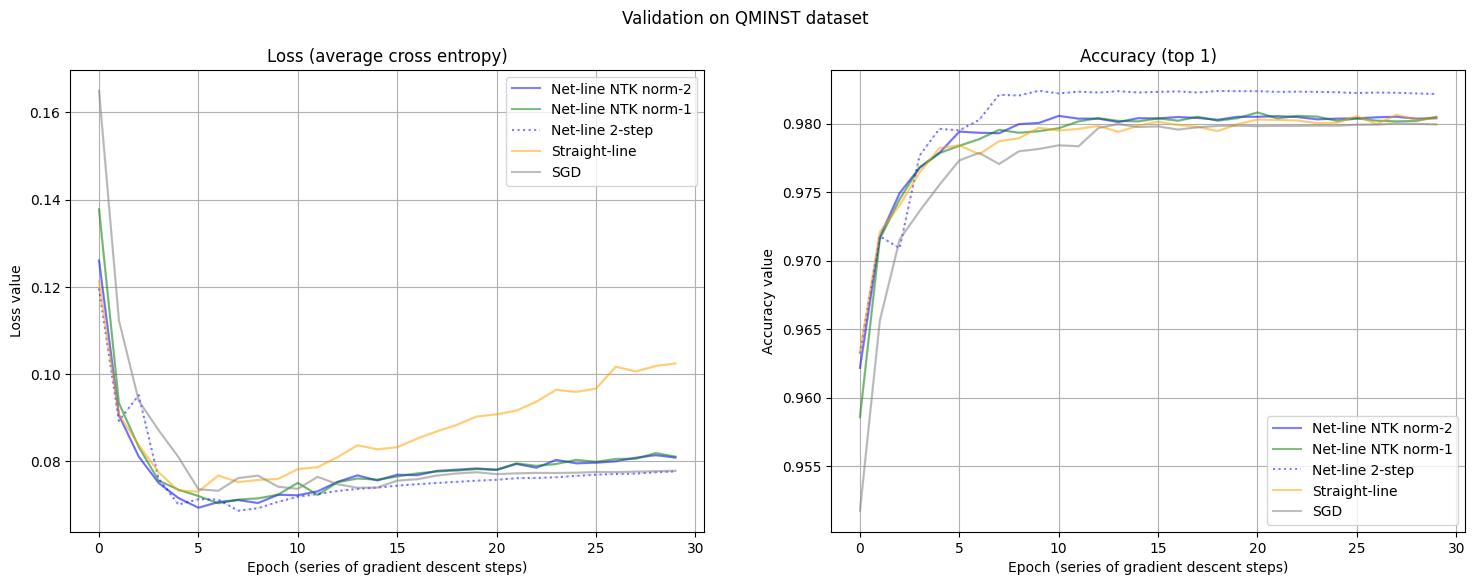

In [10]:
experimental_mean = np.mean(experimental_results, axis=0)
experimental_var = np.var(experimental_results, axis=0)
title2="Validation on QMINST dataset"
experiment_comparison(experimental_mean[0:epoch+1], experimental_var[0:epoch+1], 0, 100, title=title2)


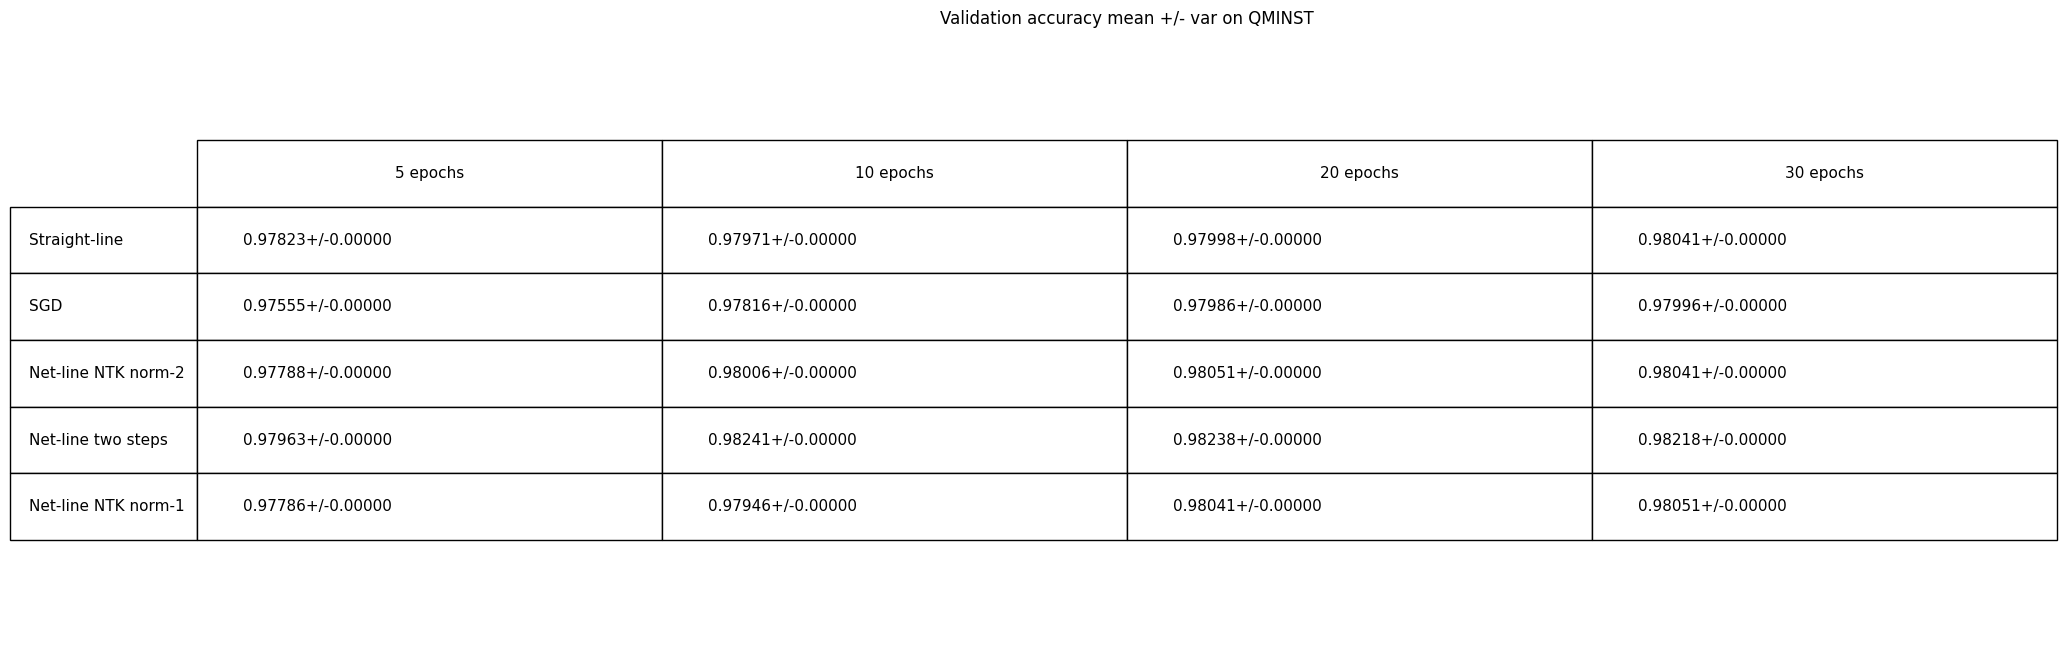

In [11]:
title3 = "Validation accuracy mean +/- var on QMINST"
accuracy_comparison(experimental_results, 0, EPOCHS_PER_EXPERIMENT, title=title3)